# 1 year atlas close look (let's look at 2022)

In [210]:
import pandas as pd
import numpy as np
import calendar
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import image
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter
import warnings
warnings.filterwarnings("ignore")


In [211]:


def compass(r,T,s):
    return r*np.exp(1j*2*np.pi*s/T)

def init_atlas(sx,sy):
    
    plt.figure(figsize=(sx,sy))



def see_atlas(atlas,symbol_size,symbol_shape):
    #plt.scatter(0,0,s=10,marker='*')
    plt.scatter(atlas.real,atlas.imag,s=symbol_size,marker=symbol_shape)


def color_atlas(atlas,symbol_size,symbol_shape,symbol_color,cmap,T_color):
    
    get_color =  cm.get_cmap(cmap, T_color)
    plt.scatter(atlas.real,atlas.imag,s=symbol_size,marker=symbol_shape,color=get_color(symbol_color%T_color))

def atlas_view(symbol,T_symbol,atlas,symbol_size,symbol_shape,symbol_color,cmap,T_color,char_flag,T_char,char_color,char_size,cmap_char):
    
    get_color =  cm.get_cmap(cmap, T_color)
    get_char_color = cm.get_cmap(cmap_char, T_char)
    plt.scatter(atlas.real,atlas.imag,s=symbol_size,marker=symbol_shape,color=get_color(symbol_color%T_color))
    if char_flag:
        plt.text(atlas.real,atlas.imag,str(symbol%T_symbol),size=char_size,color=get_char_color(char_color%T_symbol))


def create_random_climate_data(start,end,freq):
    dt_index = pd.date_range(start=start, end=end, freq=freq)

    # Create a dataframe with random temperature, humidity, and pressure data
    
    data = {'temperature': np.random.uniform(low=-60, high=60, size=len(dt_index)),
        'humidity': np.random.uniform(low=20, high=80, size=len(dt_index)),
        'pressure': np.random.uniform(low=980, high=1020, size=len(dt_index))}
        
    climate_data = pd.DataFrame(data=data, index=dt_index)
    
    return climate_data

    
def extract_climate_data(df):
    # Extract the datetime components as numpy arrays
    year = df.index.year.values
    month = df.index.month.values
    day = df.index.day.values
    hour = df.index.hour.values
    minute = df.index.minute.values
    second = df.index.second.values

    # Extract the data columns as numpy arrays
    temperature = df['temperature'].values
    humidity = df['humidity'].values
    pressure = df['pressure'].values
    
    return year, month, day, hour, minute, second, temperature, humidity, pressure

def month_range(year, month):
    if month == 2 and calendar.isleap(year):
        return 29
    return calendar.monthrange(year, month)[1]


def compass_signed(r,T_pos,T_neg,s):
    # if s will have negative values: 
    #       positive values will range from [0,pi-
    #       negative values will range from [-pi,]

   return r*np.exp(1j*(np.pi/T_pos)*s) 

def get_colors(symbol,cmap,variable_sizes,base_size):
    
    markers = ['o' if t >= 0 else 'd' for t in symbol]
    norm = plt.Normalize(min(symbol), max(symbol))
    colors = [cmap(norm(value)) for value in symbol]
    norm_seq =norm(symbol)
    if variable_sizes:
        sizes=10+7*np.abs(symbol)
    else:
        sizes=base_size*np.ones(len(symbol))
    return  markers,norm,colors,norm_seq,sizes

def plot_atlas(atlas,symbol,cmap,alpha,sx,sy,legend_flag,variable_sizes,base_size):
    markers,norm,colors,norm_seq,sizes=get_colors(symbol,cmap,variable_sizes,base_size)
    
    init_atlas(sx,sy)
    for i in range(len(atlas)):
        plt.scatter(atlas[i].real, atlas[i].imag, color=colors[i], s=sizes[i], marker=markers[i], facecolor=colors[i], edgecolors='black', alpha=alpha)
    if legend_flag:
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))

In [212]:
# primes_list_path='./data/primes.csv'
# primes_list=pd.read_csv(primes_list_path)
def isPrime(n):
    # Check if n is less than 2
    if n < 2:
        return False

    # Check if n is divisible by any integer between 2 and the square root of n
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False

    # If none of the above conditions are met, n is prime
    return True


In [213]:
isPrime(3)

True

In [214]:
def get_eigen_atlas_2D(input_symbol,sym_src,start_index,batch_size,M,To,k_o,r_o,t_o,frac,delta_0,root_phase,root_norm,r_phase,r_norm,f_log_scat,f_psi):
#Variables preallocation
    symbol=np.zeros(batch_size,dtype=int)
    is_n_prime=np.zeros(batch_size,dtype=int)
    is_symbol_prime=np.zeros(batch_size,dtype=int)
    is_n_fibo=np.zeros(batch_size,dtype=int)
    is_symbol_fibo=np.zeros(batch_size,dtype=int)
    r_time_v   =np.zeros(batch_size,dtype=float)
    zeta_symbol     =np.zeros(batch_size,dtype=complex)
    z_log_scat =np.zeros(batch_size,dtype=complex)
    psi_v     =np.zeros(batch_size,dtype=complex)
    cplx_index =np.zeros(batch_size,dtype=complex)
    psi_v_z=np.zeros(batch_size,dtype=complex)
    z_time_norm_phase= np.zeros(batch_size,dtype=complex)
    z_carrier_information=np.zeros(batch_size,dtype=float)
    psi_v_information=np.zeros(batch_size,dtype=float)
    z_time_phase = np.zeros(batch_size,dtype=complex)
    z_time_norm  = np.zeros(batch_size,dtype=complex)
    z_time=np.zeros(batch_size,dtype=complex)
    z_carrier_alpha=np.zeros(batch_size,dtype=float)
    z_carrier_beta=np.zeros(batch_size,dtype=float)
    z_carrier=np.zeros(batch_size,dtype=complex)

    index       = np.arange(start_index,batch_size,dtype=int)  
    nmod = index%To
    smod = input_symbol%M
    wzero_time = 2 * np.pi * (1/To) 
    wzero_symbol=2 * np.pi * (1/M)

    for n in index:
        
        # Index bending
        if nmod[n]==0:
            r_time_v[n]=r_time_v[n-1]+delta_0
        else:
            r_time_v[n]=r_time_v[n-1]
        
        cplx_index[n]=r_time_v[n]*np.exp(1j * wzero_time * n )
        
        
        z_time_phase[n] = ((n+1)/r_o) * np.exp(1j * ((r_o)/r_phase) * (n+1) )
        z_time_norm[n]  = (n+1) * r_norm
        z_time_norm_phase[n]  = (n+1) * r_norm**(((r_o)/r_phase) * (n+1))
        z_time[n]=z_time_norm[n]/z_time_phase[n]
        z_carrier_alpha[n]=(r_o+t_o-(frac/r_o)*n)*z_time[n].real
        z_carrier_beta[n]=(r_o+t_o-(frac*root_norm)*n)*z_time[n].imag
        z_carrier[n]=z_carrier_alpha[n]+1j*z_carrier_beta[n]
        
        # Symbol bending
        
        if sym_src=='nmod':
            symbol[n]      = nmod[n] # symbols follow events index
        elif sym_src=='input':
            symbol[n]     = input_symbol[n] # input symbol (curated representation of discretized reality )
        elif sym_src=='rand':
            symbol[n]     = random.randint(0, M) # symbols mod M from RNG
        elif sym_src=='smod':
            symbol[n]      = smod[n] # symbols mod M


        
        zeta_symbol[n]   = np.exp(1j * wzero_symbol * symbol[n])


        #Some possible marriages between time and symbols
        psi_v[n] =cplx_index[n] + f_psi*zeta_symbol[n]
        psi_v_z[n] = z_carrier[n] + f_psi*zeta_symbol[n]
        z_log_scat[n]= f_log_scat*np.log2(n+2)*zeta_symbol[n]
        z_carrier_information=np.log2(np.abs(z_carrier[n]))


        # Index moments
        if isPrime(n)==1:
            is_n_prime[n]=1
        else:
            is_n_prime[n]=0
        
        
        
        # Symbol moments
        if isPrime(symbol[n])==1:
            is_symbol_prime[n]=1
        else:
            is_symbol_prime[n]=0
        
        


    
    df = {'index':index,'nmod':nmod,'symbol':symbol,'smod':smod,'cplx_index':cplx_index,'z_time_phase':z_time_phase,'z_time_norm':z_time_norm,'z_time':z_time,'z_carrier':z_carrier,'zeta_symbol':zeta_symbol,'psi_v':psi_v,'psi_v_z':psi_v_z,'z_log_scat':z_log_scat,'z_carrier_information':z_carrier_information,'z_time_norm_phase':z_time_norm_phase,'is_symbol_prime':is_symbol_prime,'is_n_prime':is_n_prime,'is_symbol_fibo':is_symbol_fibo,'is_n_fibo':is_n_fibo}
    df =pd.DataFrame(df)
    df = df.set_index('index')
    return df

In [233]:
def plot_eigen_atlas(eigen_atlas,sx,sy,start,end,allow_scatter,allow_text,allow_anim_png,mode,symbol_size,text_size,time_color,symbol_color):
    x=eigen_atlas.z_carrier.values.real 
    y=eigen_atlas.z_carrier.values.imag
    symbol=eigen_atlas.symbol.values
    smod=eigen_atlas.smod.values
    isprime=eigen_atlas.is_n_prime.values
    ff=3
    aa=0.1
    if mode=='3D':
        z=np.log(np.abs(x+1j*y))
        plt.style.use('dark_background')
        plt.rcParams.update({
        "lines.color": "black",
        "patch.edgecolor": "black",
        "text.color": "black",
        "axes.facecolor": "black",
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "grid.color": "black",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black"})
        fig = plt.figure(figsize=(sx,sy))
        ax = fig.add_subplot(111, projection='3d')
        ax.grid(False)
        ax.w_xaxis.pane.fill = False
        ax.w_yaxis.pane.fill = False
        ax.w_zaxis.pane.fill = False
        
    elif mode=='2D':
        a=1111
        
            
    
    for n in np.arange(start,end):

        
            if allow_scatter:
                
                if isprime[n]:
                    
                    ax.scatter(x[n],y[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_2*ff*3,marker=L_0,alpha=0.8)
                    ax.scatter(x[n],-y[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(-x[n],y[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(-x[n],-y[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(y[n],x[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_1,alpha=0.3)                    
                    ax.scatter(y[n],-x[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)                    
                    ax.scatter(-y[n],x[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)                    
                    ax.scatter(-y[n],-x[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)                    
                    
                    ax.text(x[n]+aa,y[n]+aa,-z[n]+aa,str(n), color=symbol_color(symbol[n-0]), size=text_size[n])

                    ax.scatter(x[n],y[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff*6,marker=L_0,alpha=0.8)
                    ax.scatter(x[n],-y[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(-x[n],y[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(-x[n],-y[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.2)
                    ax.scatter(y[n],x[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_1,alpha=0.3)                    
                    ax.scatter(y[n],-x[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)                    
                    ax.scatter(-y[n],x[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)                    
                    ax.scatter(-y[n],-x[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_4*ff,marker=L_3,alpha=0.3)
                    if allow_text:
                        ax.text(x[n]+aa,y[n]+aa,z[n]+aa,str(n), color='white', size=text_size[n])

                    #
                    # ax.scatter(x[n],z[n],y[n],color='aqua',s=sz_1*ff*2,marker=L_0)
                    # ax.scatter(x[n],z[n],-y[n],color='brown',s=sz_2*ff,marker=L_1,alpha=0.2)
                    # ax.scatter(x[n],-z[n],y[n],color='aqua',s=sz_3*ff,marker=L_2,alpha=0.2)
                    # ax.scatter(x[n],-z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],z[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],-z[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],-z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.2)
                    #
                    
                    # #
                    # ax.scatter(y[n],z[n],y[n],color='aqua',s=sz_1*ff*2,marker=L_0)
                    # ax.scatter(y[n],z[n],-y[n],color='brown',s=sz_2*ff,marker=L_1,alpha=0.3)
                    # ax.scatter(y[n],-z[n],y[n],color='aqua',s=sz_3*ff,marker=L_2,alpha=0.2)
                    # ax.scatter(y[n],-z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-y[n],z[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-y[n],z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-y[n],-z[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-y[n],-z[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # #
                    # ax.scatter(z[n],x[n],y[n],color='aqua',s=sz_1*ff*2,marker=L_0)
                    # ax.scatter(z[n],x[n],-y[n],color='brown',s=sz_2*ff,marker=L_1,alpha=0.3)
                    # ax.scatter(z[n],-x[n],y[n],color='aqua',s=sz_3*ff,marker=L_2,alpha=0.2)
                    # ax.scatter(z[n],-x[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],x[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],x[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],-x[n],y[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],-x[n],-y[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # #
                    # ax.scatter(z[n],y[n],x[n],color='aqua',s=sz_1*ff*2,marker=L_0)
                    # ax.scatter(z[n],y[n],-x[n],color='brown',s=sz_2*ff,marker=L_1,alpha=0.3)
                    # ax.scatter(z[n],-y[n],x[n],color='aqua',s=sz_3*ff,marker=L_2,alpha=0.2)
                    # ax.scatter(z[n],-y[n],-x[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],y[n],x[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],y[n],-x[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],-y[n],x[n],color='aqua',s=sz_4*ff,marker=L_3,alpha=0.3)
                    # ax.scatter(-z[n],-y[n],-x[n],color='brown',s=sz_4*ff,marker=L_3,alpha=0.3)
                    #
                 
                else:
                    ax.scatter(x[n],y[n],z[n],color=symbol_color(symbol[n-d_0]),s=sz_1,marker=L_1)
                    ax.scatter(x[n],-y[n],z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    ax.scatter(-x[n],y[n],z[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    ax.scatter(-x[n],-y[n],z[n],color='gray',s=sz_4,marker=L_3,alpha=0.3)
                    ax.scatter(y[n],x[n],z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    ax.scatter(y[n],-x[n],z[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    ax.scatter(-y[n],x[n],z[n],color='gray',s=sz_4,marker=L_3,alpha=0.3)
                    ax.scatter(-y[n],-x[n],z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    
                    #
                    ax.scatter(x[n],y[n],-z[n],color=symbol_color(symbol[n-d_0]),s=sz_1,marker=L_1)
                    ax.scatter(x[n],-y[n],-z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    ax.scatter(-x[n],y[n],-z[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    ax.scatter(-x[n],-y[n],-z[n],color='gray',s=sz_4,marker=L_3,alpha=0.3)
                    ax.scatter(y[n],x[n],-z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    ax.scatter(y[n],-x[n],-z[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    ax.scatter(-y[n],x[n],-z[n],color='gray',s=sz_4,marker=L_3,alpha=0.3)
                    ax.scatter(-y[n],-x[n],-z[n],color='gray',s=sz_2,marker=L_1,alpha=0.3)
                    #
                    # ax.scatter(x[n],z[n],y[n],color='gray',s=sz_1*2,marker=L_0)
                    # ax.scatter(x[n],z[n],-y[n],color='gray',s=sz_2,marker=L_1,alpha=0.2)
                    # ax.scatter(x[n],-z[n],y[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    # ax.scatter(x[n],-z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],z[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],-z[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-x[n],-z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # #
                    # ax.scatter(y[n],x[n],z[n],color='gray',s=sz_1*2,marker=L_0)
                    # ax.scatter(y[n],x[n],-z[n],color='gray',s=sz_2,marker=L_1,alpha=0.2)
                    # ax.scatter(y[n],-x[n],z[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    # ax.scatter(y[n],-x[n],-z[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],x[n],z[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],x[n],-z[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],-x[n],z[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],-x[n],-z[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # #
                    # ax.scatter(y[n],z[n],y[n],color='gray',s=sz_1*2,marker=L_0)
                    # ax.scatter(y[n],z[n],-y[n],color='gray',s=sz_2,marker=L_1,alpha=0.2)
                    # ax.scatter(y[n],-z[n],y[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    # ax.scatter(y[n],-z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],z[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],-z[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-y[n],-z[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # #
                    # ax.scatter(z[n],x[n],y[n],color='gray',s=sz_1*2,marker=L_0)
                    # ax.scatter(z[n],x[n],-y[n],color='gray',s=sz_2,marker=L_1,alpha=0.2)
                    # ax.scatter(z[n],-x[n],y[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    # ax.scatter(z[n],-x[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],x[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],x[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],-x[n],y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],-x[n],-y[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # #
                    # ax.scatter(z[n],y[n],x[n],color='gray',s=sz_1*2,marker=L_0)
                    # ax.scatter(z[n],y[n],-x[n],color='gray',s=sz_2,marker=L_1,alpha=0.2)
                    # ax.scatter(z[n],-y[n],x[n],color='gray',s=sz_3,marker=L_2,alpha=0.2)
                    # ax.scatter(z[n],-y[n],-x[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],y[n],x[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],y[n],-x[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],-y[n],x[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    # ax.scatter(-z[n],-y[n],-x[n],color='gray',s=sz_4,marker=L_3,alpha=0.2)
                    
                    
                
                if allow_anim_png:
                  plt.savefig('./img/eigen_atlas/geometric_numbers_%d.png' % n)



                    

In [215]:
def generate_primes(n):
    primes = []
    sieve = [True] * (n+1)
    p = 2
    while p * p <= n:
        if sieve[p]:
            for i in range(p * p, n+1, p):
                sieve[i] = False
        p += 1
    for p in range(2, n+1):
        if sieve[p]:
            primes.append(p)
    return primes





In [216]:

plt.rcParams.update({
        "lines.color": "black",
        "patch.edgecolor": "white",
        "text.color": "white",
        "axes.facecolor": "black",
        "axes.edgecolor": "black",
        "axes.labelcolor": "black",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "gray",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black"})




In [217]:

# Example use
start = pd.Timestamp('2023-01-01 00:00:00')
end = pd.Timestamp('2023-01-31 23:00:00')
freq ='H'
df  = create_random_climate_data(start,end,freq)
year, month, day, hour, minute, second, temperature, humidity, pressure = extract_climate_data(df)

# Main index
n = np.arange(len(df.index))
h    = n
h_24 = hour
d    = day
m    = month
y    = year

# Structural index
year_clk    =   compass(r=(2)**(0),T=7,s=year)
month_clk   =   compass(r=(2)**(-2.3),T=12,s=month)
day_clk     =   compass(r=(2)**(-4.5),T=31,s=day)
hour_clk    =   compass(r=(2)**(-8),T=24,s=n)

#temp_symbol =   compass(r=1,T=)

smaller_clock = hour_clk
clk_0   =   smaller_clock
clk_1   =   day_clk
clk_2   =   month_clk
clk_3   =   year_clk


atlas = clk_0+clk_1+clk_2+clk_3



# Adapt the data to the time structure

Here are no general rules. You can use your compas however you like.
As we are testing with climate data, and with possitive and negative numbers we have to adapt our data to our clocks structure.

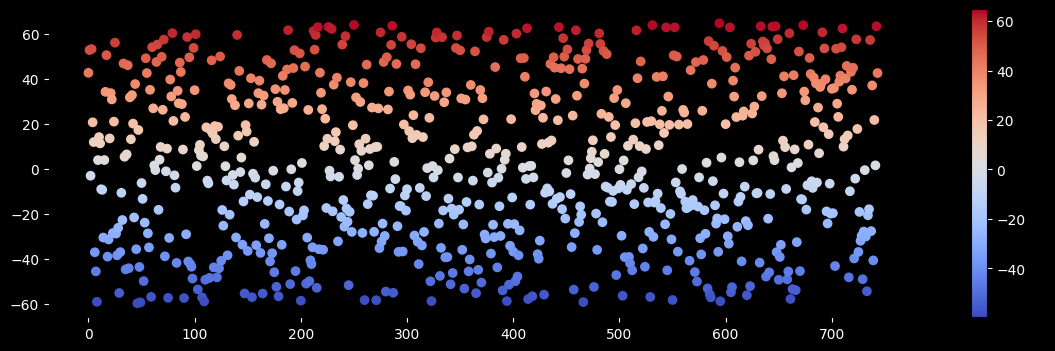

In [218]:
MAX=60
MIN=-60
K=3
n=n
seq_size=n.size
# symbol = np.arange(-60,61,0.5)
# symbol = np.random.randint(-60,61,300)
#symbol = np.random.rand(int(seq_size))*MAX + np.random.rand(seq_size)*MIN
symbol    = np.random.uniform(low=-60, high=65, size=seq_size)
cmap = plt.cm.coolwarm
norm = plt.Normalize(min(symbol), max(symbol))
colors = [cmap(norm(value)) for value in symbol]
init_atlas(14,4)

plt.scatter(np.arange(len(symbol)), symbol, color=colors)
#plt.plot(np.arange(len(symbol)), symbol)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
cbar.set_label('Color for Positive and Negative Values')

plt.show()

In [219]:
atlas.size

744

# The sine function in 1 month atlas

$$s = r_s*\sin(\frac{2\pi}{24}n) $$

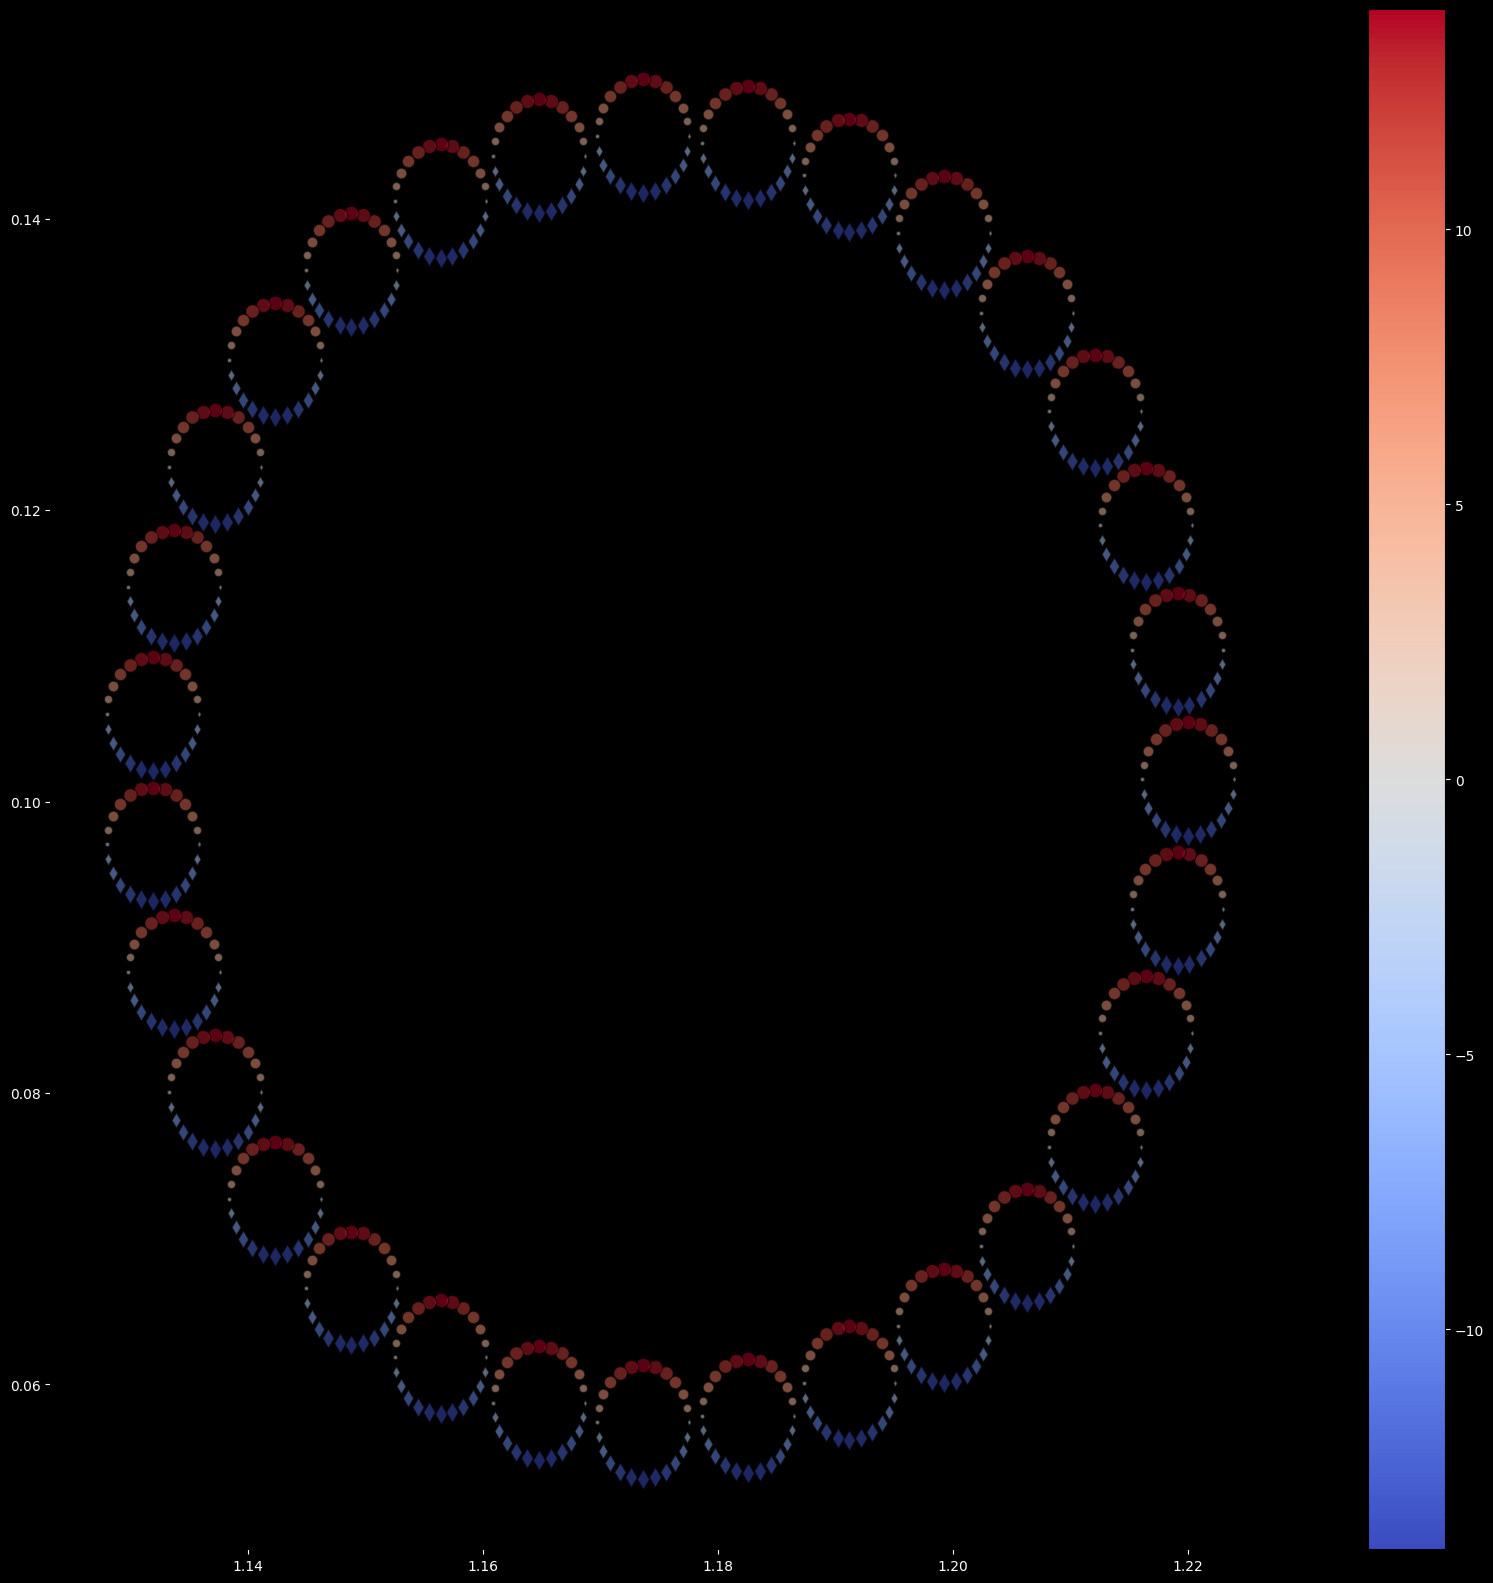

In [220]:
symbol    =14*np.sin(2*np.pi/24*np.arange(len(atlas)))
cmap=plt.cm.coolwarm
plot_atlas(atlas=atlas,symbol=symbol,cmap=cmap,alpha=0.5,sx=20,sy=20,legend_flag=1,variable_sizes=1,base_size=1)

## Hour number 31 days

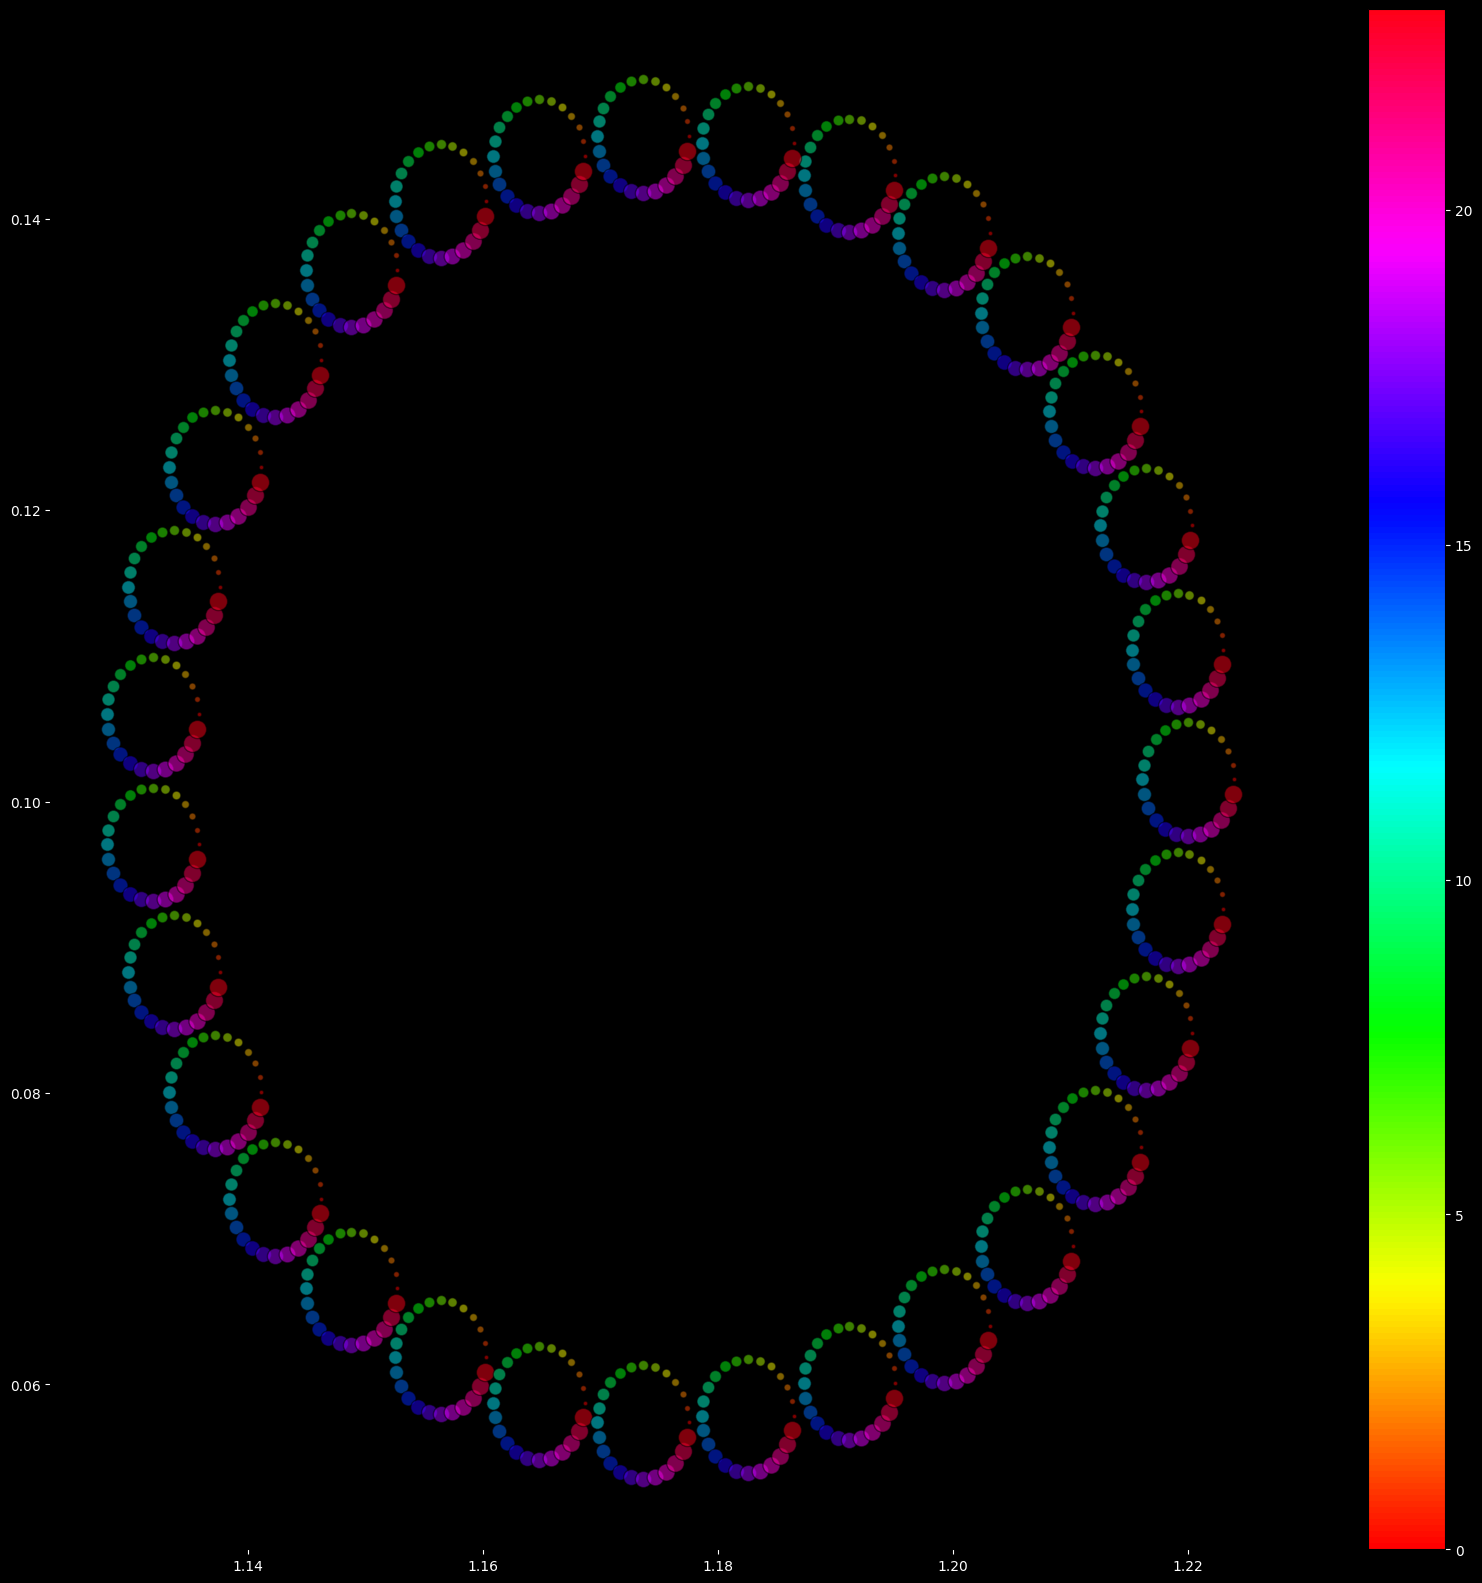

In [221]:
# Structural index
year_clk    =   compass(r=(2)**(0),T=7,s=year)
month_clk   =   compass(r=(2)**(-2.3),T=12,s=month)
day_clk     =   compass(r=(2)**(-4.5),T=31,s=day)
hour_clk    =   compass(r=(2)**(-8),T=24,s=n)

#temp_symbol =   compass(r=1,T=)

smaller_clock = hour_clk
clk_0   =   smaller_clock
clk_1   =   day_clk
clk_2   =   month_clk
clk_3   =   year_clk


atlas = clk_0+clk_1+clk_2+clk_3
plot_atlas(atlas=atlas,symbol=hour,cmap=plt.cm.hsv,alpha=0.5,sx=20,sy=20,legend_flag=1,variable_sizes=1,base_size=1)

## Other variations

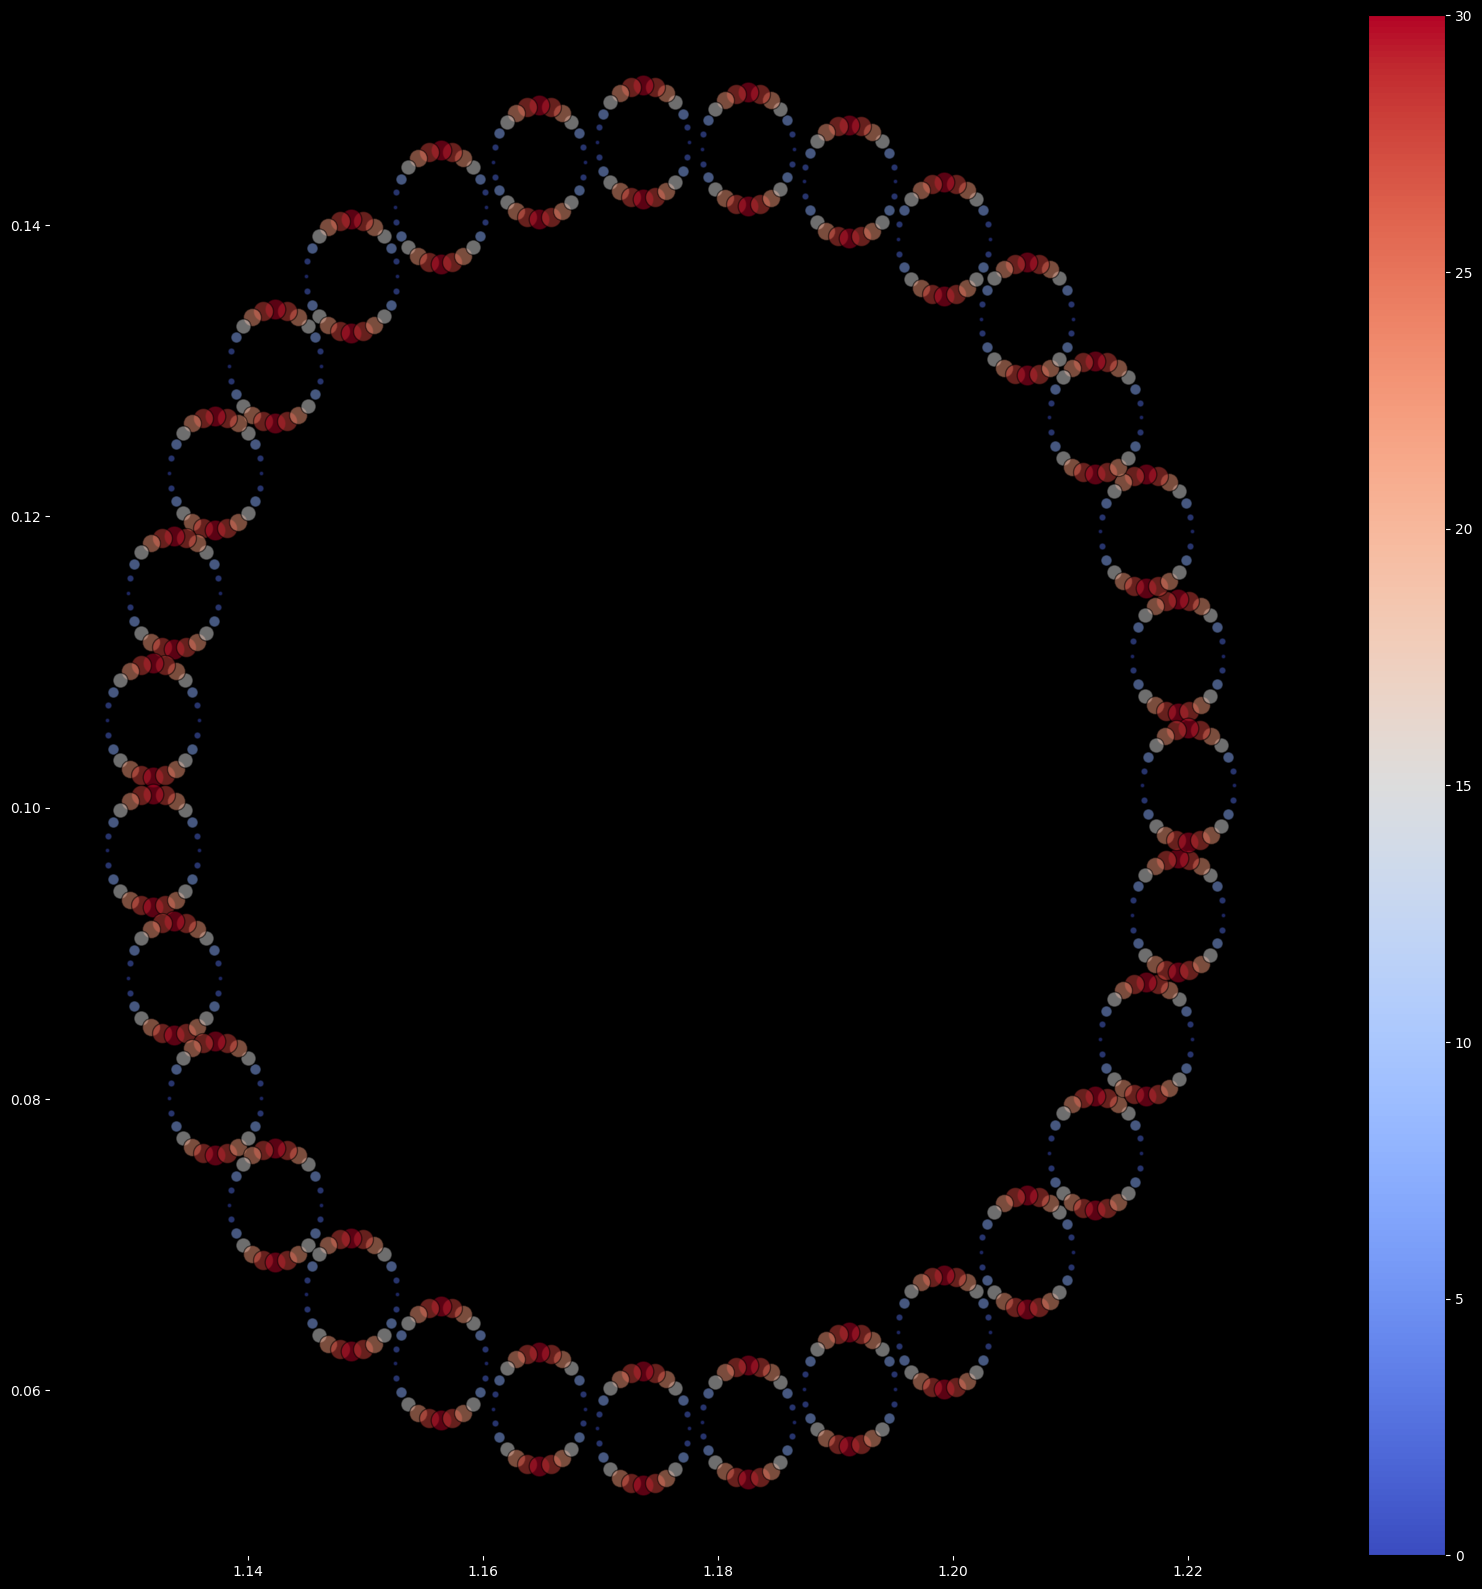

In [222]:
plot_atlas(atlas=atlas,symbol=30*np.sin(2*np.pi*hour/24)**2,cmap=plt.cm.coolwarm,alpha=0.5,sx=20,sy=20,legend_flag=1,variable_sizes=1,base_size=1)

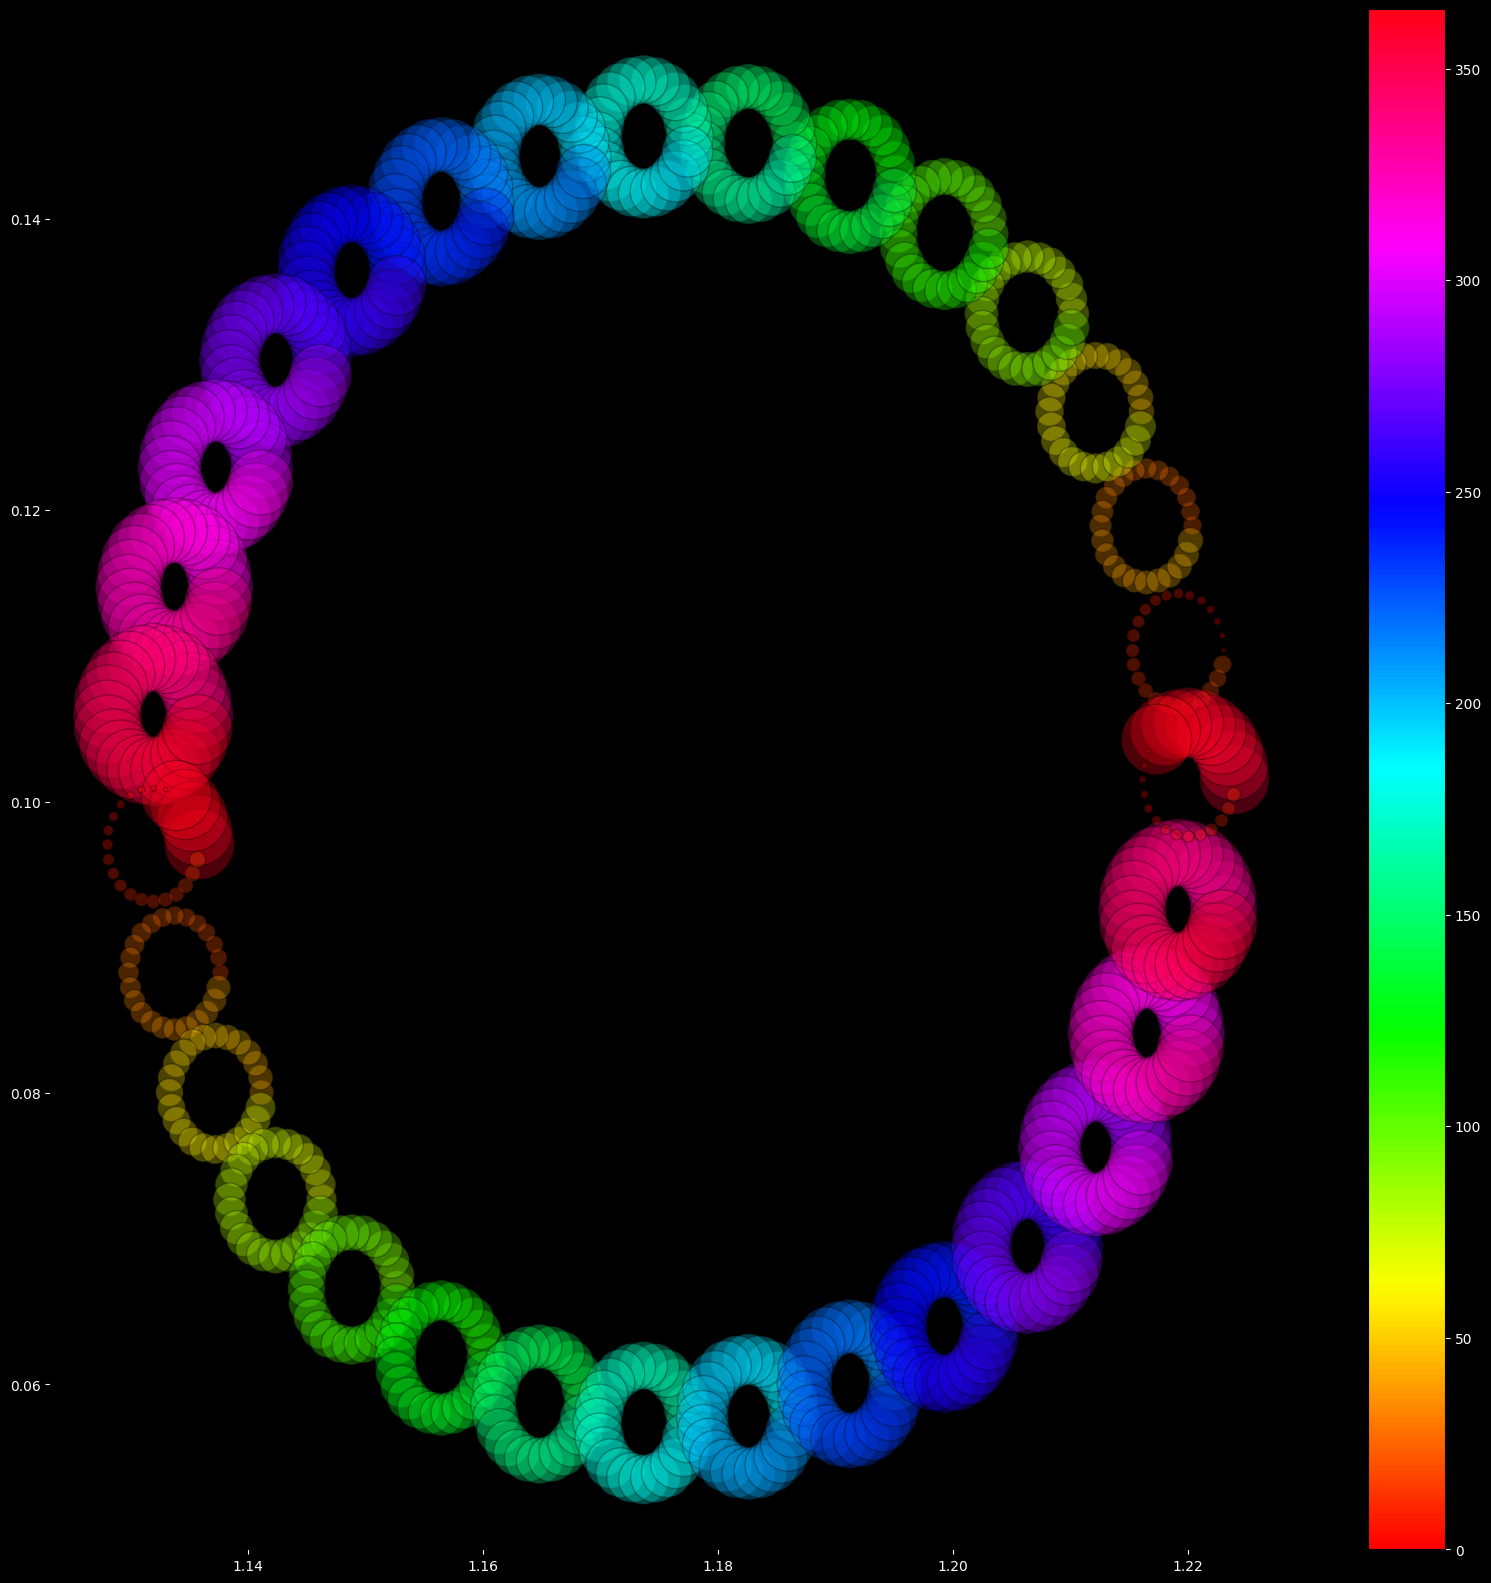

In [223]:
plot_atlas(atlas=atlas,symbol=n%365,cmap=plt.cm.hsv,alpha=0.3,sx=20,sy=20,legend_flag=1,variable_sizes=1,base_size=1)

## Random symbol

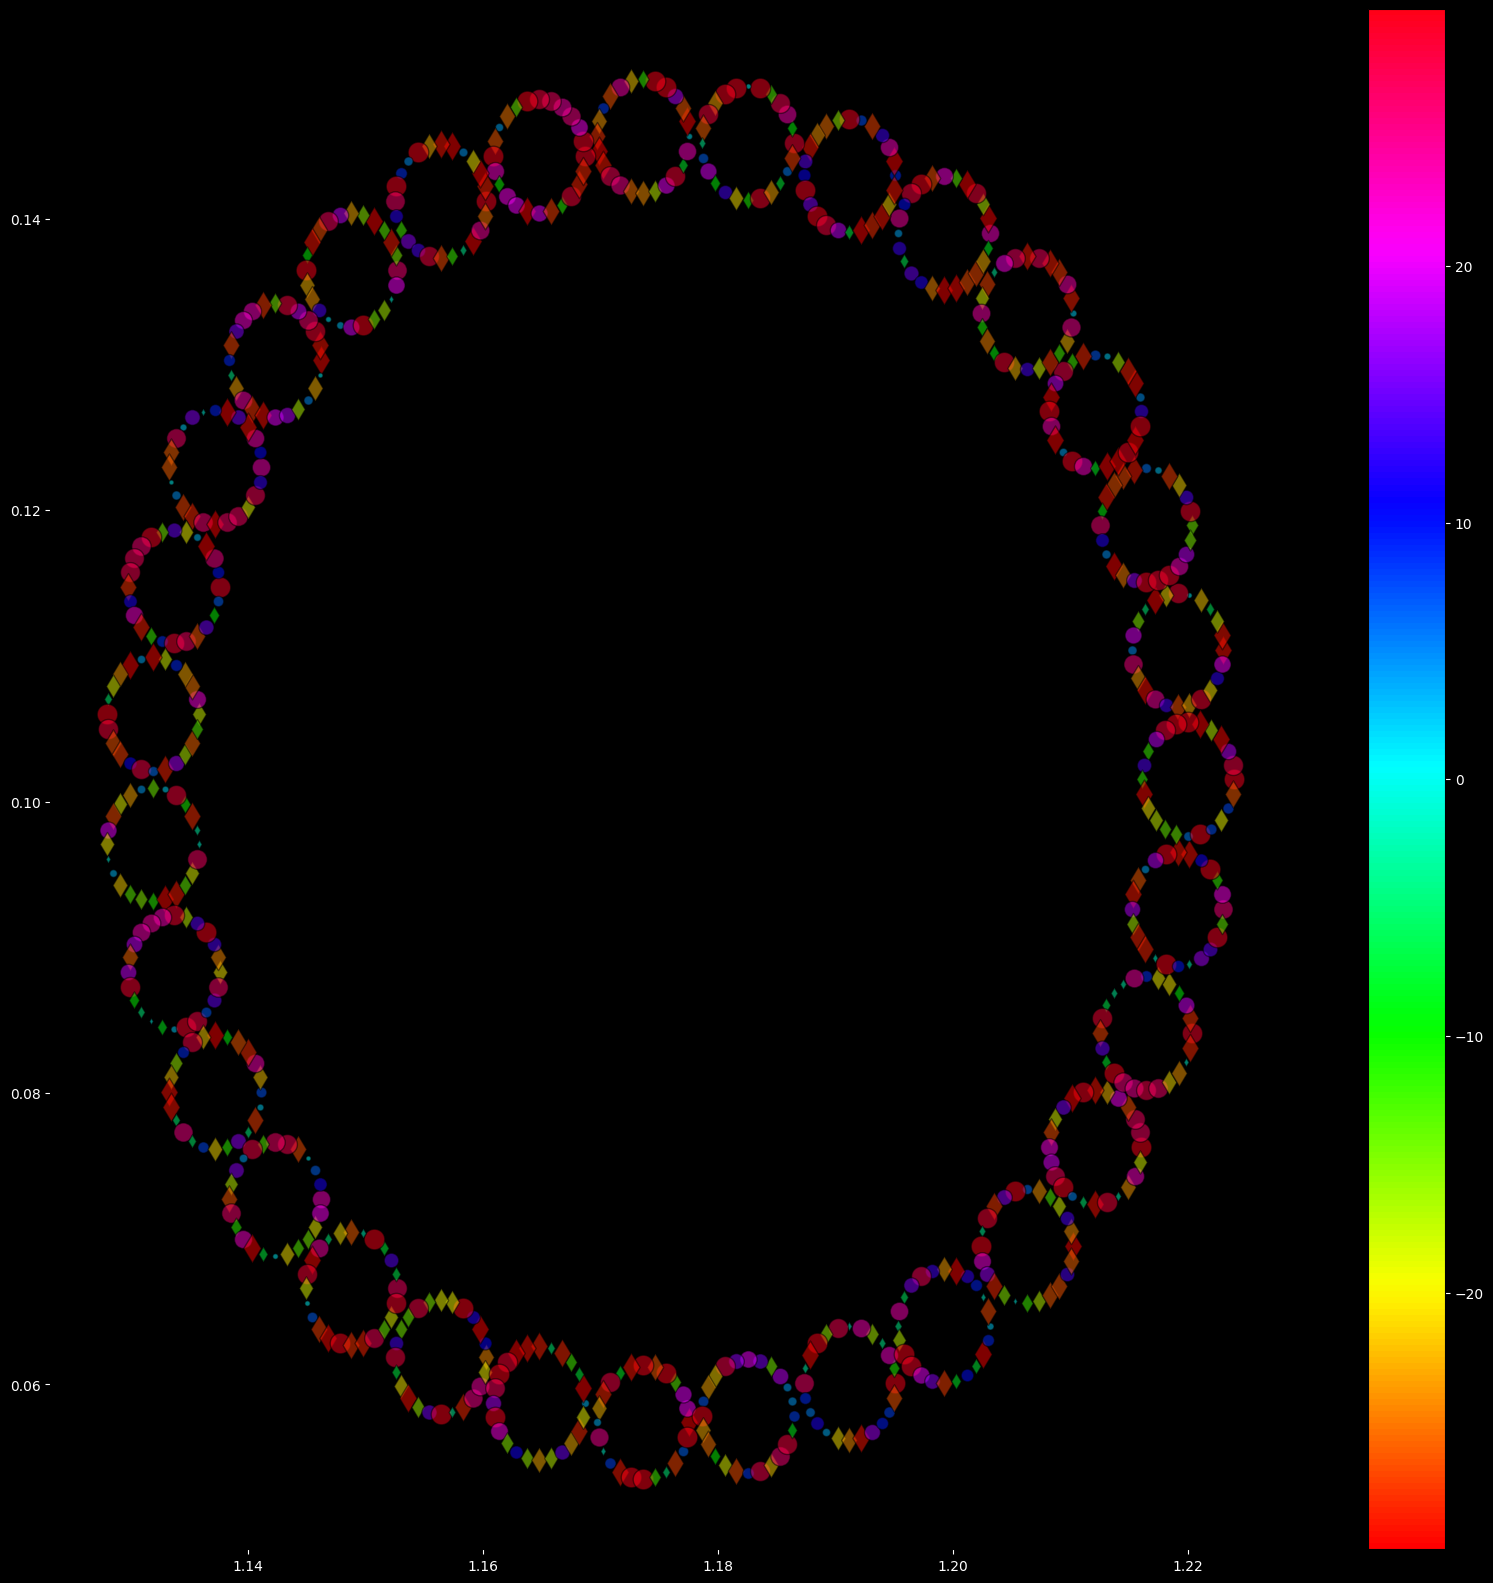

In [224]:

plot_atlas(atlas=atlas,symbol=30*np.sin(2*np.pi*temperature/60),cmap=plt.cm.hsv,alpha=0.5,sx=20,sy=20,legend_flag=1,variable_sizes=1,base_size=1)


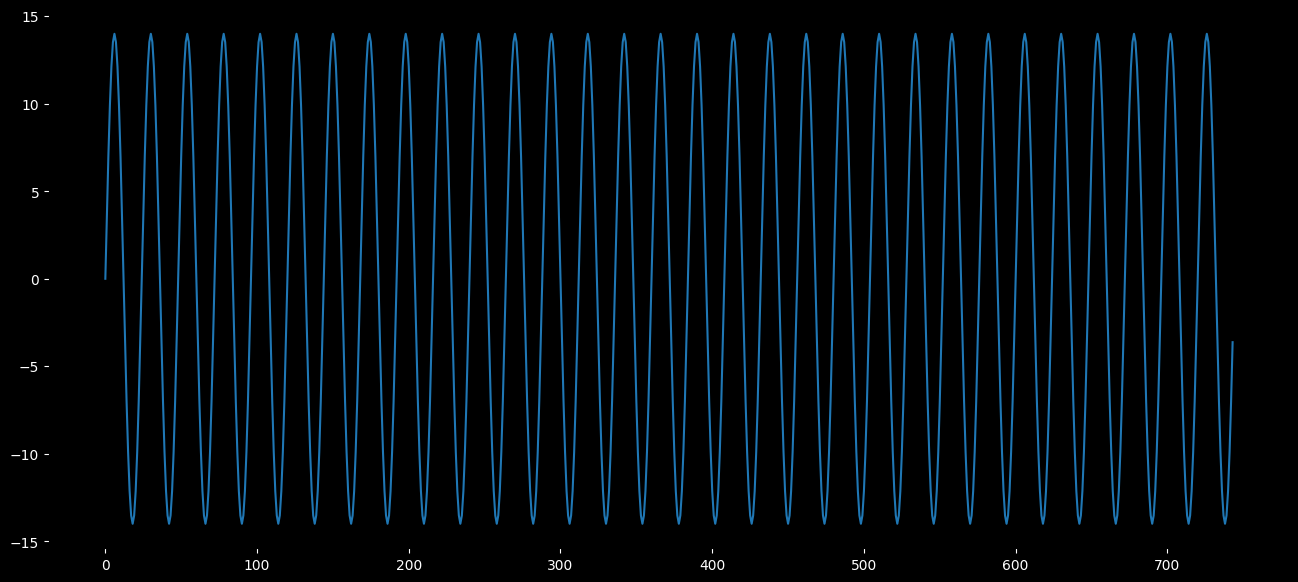

In [225]:
init_atlas(16,7)
plt.plot(symbol)

## Custom structure - a 360 days year simplification

If we didn't use the datetime structure from python, we could imagine we design our own calendar going from the most simple one to understand of one year of 360 days (to be 1 )

In [226]:
T_0=24
T_1=30
T_2=12
T_3=1
n=np.arange(T_0*T_1*T_2*T_3)
s_0=n
s_1=n%T_1
s_2=n%T_2
s_3=n%T_3


## Eigen Atlas



In [227]:
# Inputs for basic eigen_atlas plot
sessions    = 3
To=39
M=To
sym_src='input' # 'nmod' , 'input' or 'rand'
start_index=0






stretch_space=4 # 4 is one "natural" factor
stretch_time=3 # 3 is one 'natural' factor 
phase=5
norm=3
frac=1/2



  
#Initial conditions

k_o         = 1/stretch_time
k_1 =1/(stretch_space*To)
r_o=To*k_1
t_o=To*k_o
 
delta_0 = 1/To

f_psi=1/10
f_log_scat = 1/10

#root impedances - initial conditions
root_phase=np.sqrt(phase)
root_norm=np.sqrt(norm)
r_phase=frac*(1+root_phase)
r_norm=frac*(1+1j*root_norm)

# Input symbols
                          


In [231]:

# Symbol follow the index
input_symbol=hour
batch_size  = input_symbol.size
sym_src='input' # 'nmod' , 'input' or 'rand'
eigen_atlas=get_eigen_atlas_2D(input_symbol,sym_src,start_index,batch_size,M,To,k_o,r_o,t_o,frac,delta_0,root_phase,root_norm,r_phase,r_norm,f_log_scat,f_psi)

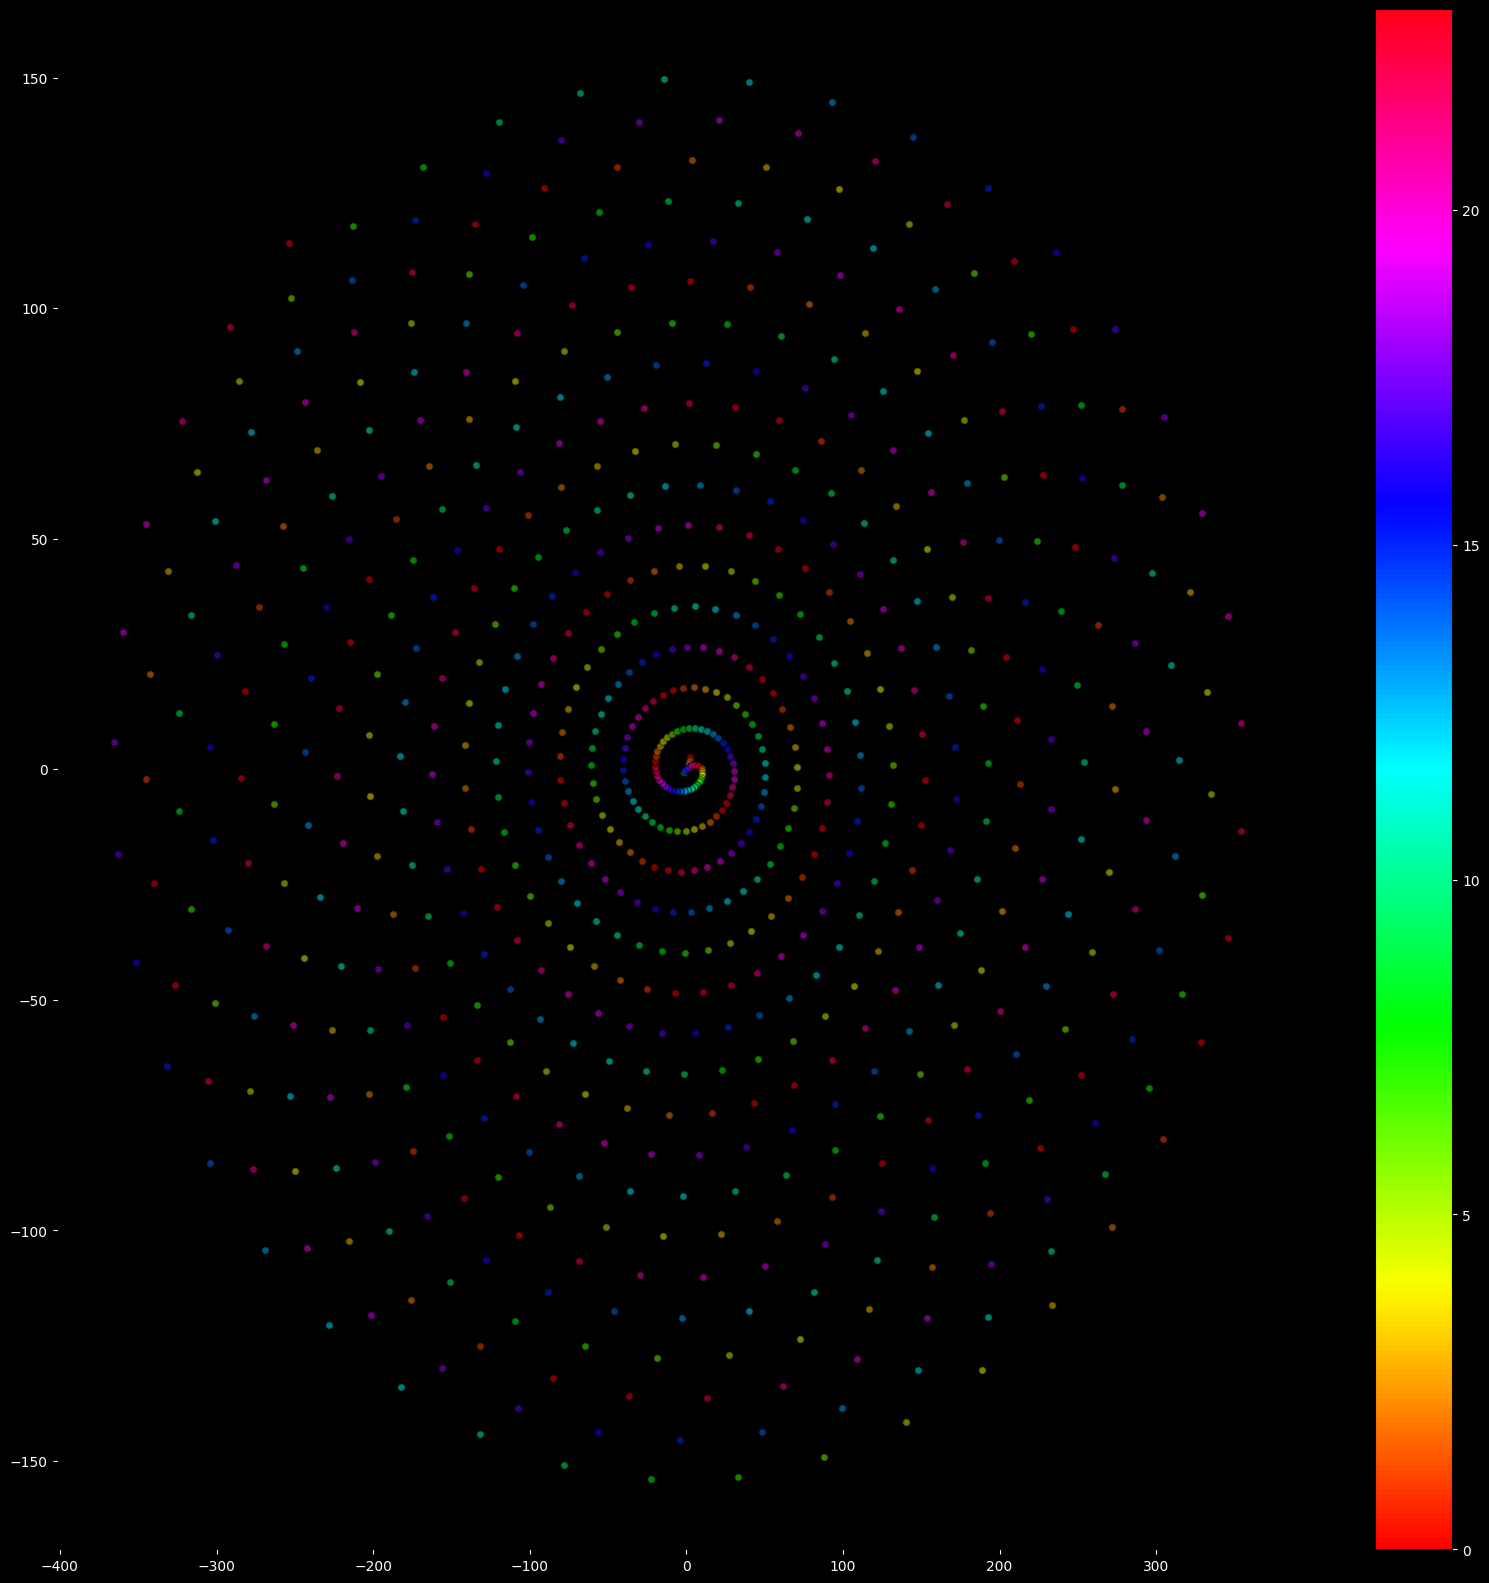

In [232]:
z_carrier=eigen_atlas.z_carrier.values
plot_atlas(atlas=z_carrier[0:1000],symbol=input_symbol[0:1000],cmap=plt.cm.hsv,alpha=0.5,sx=20,sy=20,legend_flag=1,variable_sizes=0,base_size=29)


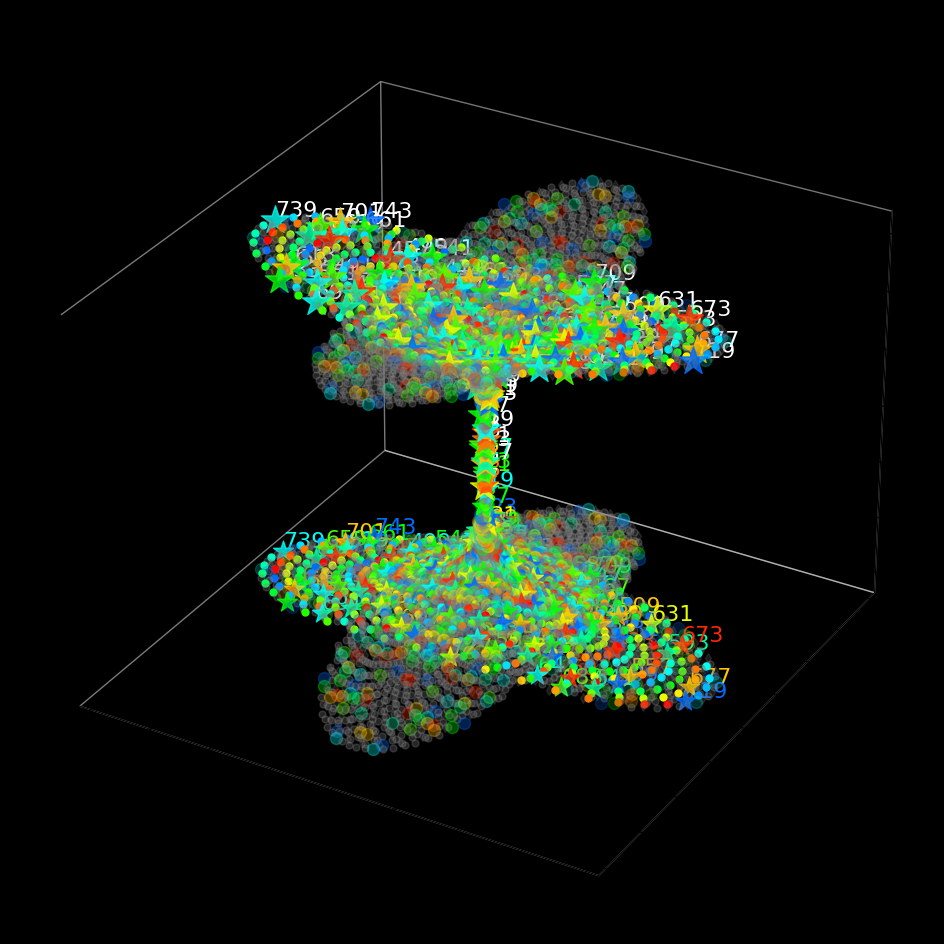

In [234]:
# Start and end index
start=0
end=batch_size

#Plot settings (flags)
allow_plot = 1
allow_scatter = 1
allow_text = 1
allow_anim_png = 0
mode ='3D' # '2D' or '3D' 

#Plot constants
base_symbol_size=25
base_text_size=16
dots_per_inch=300
L_0="*"
L_1="o"
L_2="d"
L_3="o"
L_4="d"
L_5="o"
L_6="d"
L_7="o"
d_0=0
d_1=1
d_2=2
d_3=3
d_4=4
d_5=5
d_6=6
d_7=7
jump=0
sz_1=base_symbol_size
sz_2=sz_1+jump
sz_3=sz_2+jump
sz_4=sz_3+jump
sz_5=sz_4+jump
sz_6=sz_5+jump
sz_7=sz_6+jump
sz_8=sz_7+jump
colormap_time='hsv'
colormap_symbol='hsv'
sx=20
sy=12

alpha_non_prime=0.22
# Plot colors
time_color = cm.get_cmap(colormap_time, To)
symbol_color  =cm.get_cmap(colormap_symbol, M)


symbol_size =base_symbol_size*np.ones(batch_size,dtype=int)
text_size =base_text_size*np.ones(batch_size,dtype=int)
allow_anim_png=0
#plot_eigen_atlas(eigen_atlas,sx,sy,start,end,allow_scatter,allow_text,allow_anim_png,mode,symbol_size,text_size,time_color,symbol_color)

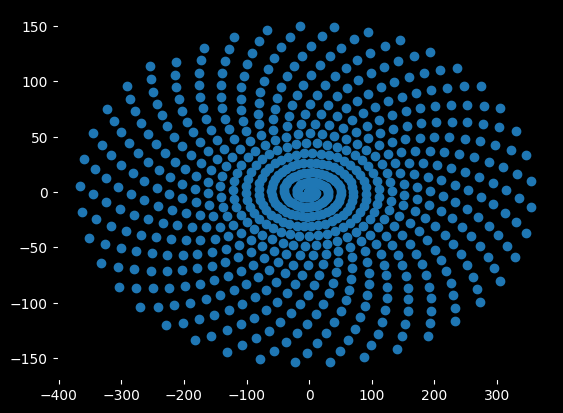

In [230]:
plt.scatter(z_carrier.real,z_carrier.imag)